In [28]:
import pandas as pd
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.experimental import enable_halving_search_cv
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV, RepeatedKFold

In [29]:
import random
random.seed(42)
random_seed = 42
search_factor = 4
search_n_candidates = search_factor ** 3 # candidates = search_factor ** n_rounds
search_agg_elimination = True
search_cv = 5
search_scoring = 'neg_root_mean_squared_error' # 'explained_variance'
search_n_jobs = -1
search_verbose = 0

### Data

In [30]:
file = r'dataset-container-cpu-mem-replica.csv'
df_unique = pd.read_csv(file)

# dataset
dataset = df_unique.values

X = dataset[:, 2] # cpu column
print(np.min(X)," ",np.max(X))
print(len(X))

Y = dataset[:, 3] # mem column
print(np.min(Y)," ",np.max(Y))
print(len(Y))

1.3539901646090537e-05   15.989687048076078
19440
0.574042426   173.71871731171544
19440


Reshape + Split

In [31]:
X = X.reshape(-1, 1)
Y = Y.reshape(-1, 1)

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)
print("Train: ", X_train.shape)
print("Val: ", X_val.shape)
print("Test: ", X_test.shape)

Train:  (12441, 1)
Val:  (3111, 1)
Test:  (3888, 1)


In [32]:
'''plt.figure(figsize=(9, 5), dpi=120)
plt.scatter(x=X, y=Y, color="#59bbf7", marker="o",alpha=0.5, edgecolors="#0991e6")
plt.subplot().tick_params(labelsize=25)
plt.ylabel('X', fontsize=25)
plt.xlabel('Y', fontsize=25)
plt.show()'''

'plt.figure(figsize=(9, 5), dpi=120)\nplt.scatter(x=X, y=Y, color="#59bbf7", marker="o",alpha=0.5, edgecolors="#0991e6")\nplt.subplot().tick_params(labelsize=25)\nplt.ylabel(\'X\', fontsize=25)\nplt.xlabel(\'Y\', fontsize=25)\nplt.show()'

### GBR Model

In [33]:
'''model = GradientBoostingRegressor()
grid = dict()
grid['n_estimators'] = [10, 50, 100, 500]
grid['learning_rate'] = [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0]
grid['subsample'] = [0.5, 0.7, 1.0]
grid['max_depth'] = [3, 7, 9]
# define the evaluation procedure
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# define the grid search procedure
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv)
# execute the grid search
grid_result = grid_search.fit(X, Y)
# summarize the best score and configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_)) # summarize all scores that were evaluated
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))'''

'model = GradientBoostingRegressor()\ngrid = dict()\ngrid[\'n_estimators\'] = [10, 50, 100, 500]\ngrid[\'learning_rate\'] = [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0]\ngrid[\'subsample\'] = [0.5, 0.7, 1.0]\ngrid[\'max_depth\'] = [3, 7, 9]\n# define the evaluation procedure\ncv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)\n# define the grid search procedure\ngrid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv)\n# execute the grid search\ngrid_result = grid_search.fit(X, Y)\n# summarize the best score and configuration\nprint("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_)) # summarize all scores that were evaluated\nmeans = grid_result.cv_results_[\'mean_test_score\']\nstds = grid_result.cv_results_[\'std_test_score\']\nparams = grid_result.cv_results_[\'params\']\nfor mean, stdev, param in zip(means, stds, params):\n    print("%f (%f) with: %r" % (mean, stdev, param))'

In [34]:
# model
#'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 100, 'subsample': 0.5
gbr = GradientBoostingRegressor(subsample=0.8,
                                learning_rate=0.4,
                                n_estimators= 15,
                                max_depth=40,
                                loss="absolute_error")
'''gbr = GradientBoostingRegressor(subsample=0.5,
                                learning_rate=0.1,
                                n_estimators=100,
                                max_depth=9,
                                min_samples_split=200,
                                min_samples_leaf=40,
                                loss="absolute_error")'''

'gbr = GradientBoostingRegressor(subsample=0.5,\n                                learning_rate=0.1,\n                                n_estimators=100,\n                                max_depth=9,\n                                min_samples_split=200,\n                                min_samples_leaf=40,\n                                loss="absolute_error")'

Fit + Predict

In [35]:
# fit
gbr.fit(X_train, Y_train)

# prediction
Y_predict_gbr = gbr.predict(X_test)

C:\Users\b1108190\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\ensemble\_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


Errors

In [36]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
mae = mean_absolute_error(Y_test, Y_predict_gbr)
mape = mean_absolute_percentage_error(Y_test, Y_predict_gbr)
mse = mean_squared_error(Y_test, Y_predict_gbr)
rmse_test = mse ** 0.5
#mape = mean_absolute_percentage_error(Y_val, Y_predict_gbr)
#mae = mean_absolute_error(Y_val, Y_predict_gbr)
#mse = mean_squared_error(Y_val, Y_predict_gbr)
print(f"MAPE : {mape}")
print(f"MAE : {mae}")
print(f"MSE : {mse}")
print(f"RMSE: {rmse_test}")

MAPE : 0.026454907668404897
MAE : 0.25375826853643074
MSE : 3.961889885456365
RMSE: 1.9904496691592994


Loss Curve

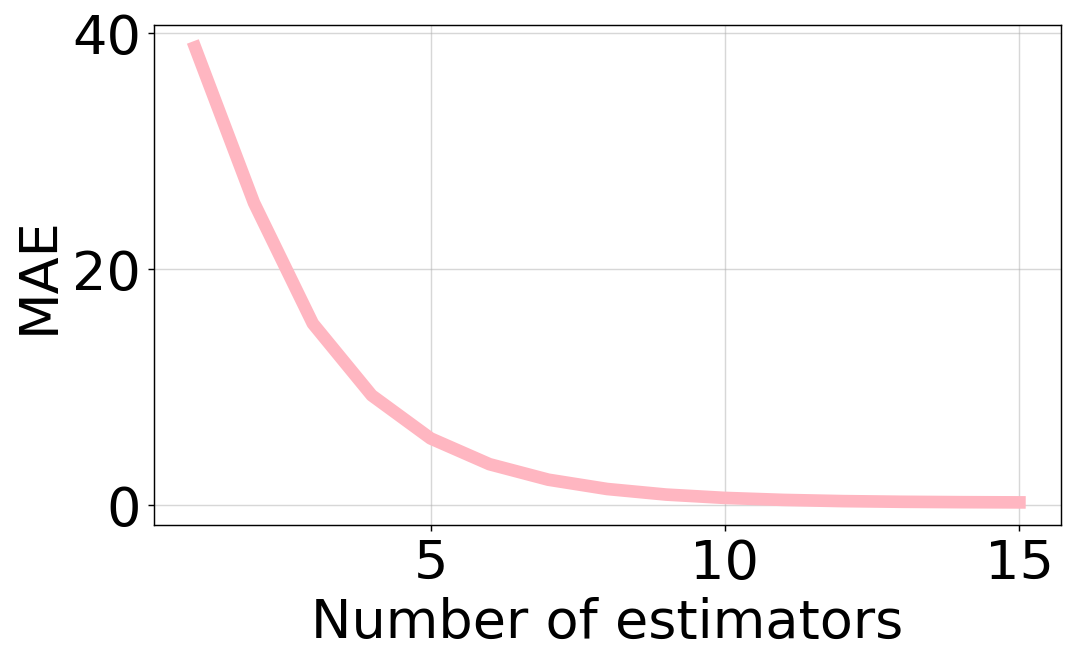

In [37]:
import matplotlib.pyplot as plt
mae = []
for Y_pred_gbr in gbr.staged_predict(X_test):
    mae.append(mean_absolute_error(Y_test, Y_pred_gbr))

fig, ax = plt.subplots(figsize=(9, 5), dpi=130)
plt.subplot().tick_params(labelsize=30)
ax.plot(np.arange(1, gbr.n_estimators + 1), mae, color='lightpink', linewidth=7)
ax.set_xlabel('Number of estimators', fontsize=30)
ax.set_ylabel('MAE', fontsize=30)
ax.grid(True, alpha=0.5)
#plt.show()
plt.savefig("gbr_validation.pdf", format="pdf", bbox_inches="tight")

Replica

In [38]:
replica_actual = []
for i in range(len(X_test)):
    replica_actual.append(np.ceil((dataset[len(X_train)+i, 4] * X_test[i])/Y_test[i]))
    #replica_actual.append(dataset[len(X_train)+i,4])
    #replica_actual.append((Y_test[i]))

replica_gbr = []
for i in range(len(X_test)):
    replica_gbr.append(np.ceil((dataset[len(X_train)+i, 4] * X_test[i])/Y_predict_gbr[i]))
    #replica_actual.append((Y_predict_gbr[i]))

In [39]:
'''from scipy.interpolate import pchip

plt.figure(figsize=(9, 5), dpi=120)
plt.subplot().tick_params(labelsize=20)
N = X_test.shape[0] #94004
X_ = np.linspace(np.arange(N).min(), np.arange(N).max(), 200) #/1000

X_Y_Spline = pchip(np.arange(N), np.array(np.ceil(replica_actual)))
Y_ = X_Y_Spline(X_)
plt.plot(X_,Y_, label='Without prediction', color="red", linestyle='dashed')

X_Y_Spline = pchip(np.arange(N), np.array(np.ceil(replica_gbr)))
Y_ = X_Y_Spline(X_)
plt.plot(X_,Y_,  label='GBR prediction', color="lightgreen", linestyle='dashed')

plt.ylabel('Number of replicas', fontsize=20)
plt.xlabel('Microservice #id', fontsize=20)
plt.legend(loc='upper center',bbox_to_anchor=(0.5, -0.2),fancybox=False, shadow=False, ncol=3, fontsize=20 ) #bbox_to_anchor =(1,1), ncol=1)
#plt.show()
plt.savefig("NumberOfReplicas.pdf", format="pdf", bbox_inches="tight")'''

'from scipy.interpolate import pchip\n\nplt.figure(figsize=(9, 5), dpi=120)\nplt.subplot().tick_params(labelsize=20)\nN = X_test.shape[0] #94004\nX_ = np.linspace(np.arange(N).min(), np.arange(N).max(), 200) #/1000\n\nX_Y_Spline = pchip(np.arange(N), np.array(np.ceil(replica_actual)))\nY_ = X_Y_Spline(X_)\nplt.plot(X_,Y_, label=\'Without prediction\', color="red", linestyle=\'dashed\')\n\nX_Y_Spline = pchip(np.arange(N), np.array(np.ceil(replica_gbr)))\nY_ = X_Y_Spline(X_)\nplt.plot(X_,Y_,  label=\'GBR prediction\', color="lightgreen", linestyle=\'dashed\')\n\nplt.ylabel(\'Number of replicas\', fontsize=20)\nplt.xlabel(\'Microservice #id\', fontsize=20)\nplt.legend(loc=\'upper center\',bbox_to_anchor=(0.5, -0.2),fancybox=False, shadow=False, ncol=3, fontsize=20 ) #bbox_to_anchor =(1,1), ncol=1)\n#plt.show()\nplt.savefig("NumberOfReplicas.pdf", format="pdf", bbox_inches="tight")'

In [40]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
print()
print("MAPE : ", np.round(mean_absolute_percentage_error(np.array(replica_actual), np.array(replica_gbr)),4))

print("MAE : ", np.round(mean_absolute_error(np.array(replica_actual), np.array(replica_gbr)),4))

print("MSE : ", np.round(mean_squared_error(np.array(replica_actual), np.array(replica_gbr)),4))

print("RMSE : ", np.round(mean_squared_error(np.array(replica_actual), np.array(replica_gbr))**0.5,4))

print("Actual number of replicas (min.): ",np.round(np.min(np.array(replica_actual)),0))
print("Predicted number of replicas (min.): ",np.round(np.min(np.array(replica_gbr)),0))

print("Actual number of replicas (avg.): ",np.round(np.average(np.array(replica_actual)),0))
print("Predicted number of replicas (avg.): ",np.round(np.average(np.array(replica_gbr)),0))

print("Actual number of replicas (max.): ",np.round(np.max(np.array(replica_actual)),0))
print("Predicted number of replicas (max.): ",np.round(np.max(np.array(replica_gbr)),0))


MAPE :  0.0018
MAE :  0.0383
MSE :  0.0383
RMSE :  0.1958
Actual number of replicas (min.):  1
Predicted number of replicas (min.):  1
Actual number of replicas (avg.):  4.0
Predicted number of replicas (avg.):  4.0
Actual number of replicas (max.):  42
Predicted number of replicas (max.):  42


In [41]:
from sklearn.svm import SVR
from sklearn.ensemble import BaggingRegressor

In [42]:
#model = BaggingRegressor(estimator=SVR())
grid = dict()
grid['n_estimators'] = [10, 50, 100]
grid['max_samples'] = [0.5, 0.7, 1.0]
'''# define the evaluation procedure
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# define the grid search procedure
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv)
# execute the grid search
grid_result = grid_search.fit(X, Y)
# summarize the best score and configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_)) # summarize all scores that were evaluated
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))'''

'# define the evaluation procedure\ncv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)\n# define the grid search procedure\ngrid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv)\n# execute the grid search\ngrid_result = grid_search.fit(X, Y)\n# summarize the best score and configuration\nprint("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_)) # summarize all scores that were evaluated\nmeans = grid_result.cv_results_[\'mean_test_score\']\nstds = grid_result.cv_results_[\'std_test_score\']\nparams = grid_result.cv_results_[\'params\']\nfor mean, stdev, param in zip(means, stds, params):\n    print("%f (%f) with: %r" % (mean, stdev, param))'

In [43]:
brr = BaggingRegressor(max_samples=5, n_estimators=100, n_jobs=-1, random_state=42).fit(X_train, Y_train)
Y_predict_brr = brr.predict(X_test)

C:\Users\b1108190\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\ensemble\_bagging.py:581: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)


In [44]:
mae = mean_absolute_error(Y_test, Y_predict_brr)
mape = mean_absolute_percentage_error(Y_test, Y_predict_brr)
mse = mean_squared_error(Y_test, Y_predict_brr)
rmse_test = mse ** 0.5
#mape = mean_absolute_percentage_error(Y_val, Y_predict_brr)
#mae = mean_absolute_error(Y_val, Y_predict_brr)
#mse = mean_squared_error(Y_val, Y_predict_brr)
print(f"MAPE : {mape}")
print(f"MAE : {mae}")
print(f"MSE : {mse}")
print(f"RMSE: {rmse_test}")

MAPE : 5.173811026023873
MAE : 12.602638374512408
MSE : 316.55820731977064
RMSE: 17.792082714504524


C:\Users\b1108190\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\ensemble\_bagging.py:581: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)
C:\Users\b1108190\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\ensemble\_bagging.py:581: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)
C:\Users\b1108190\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\ensemble\_bagging.py:581: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please chang

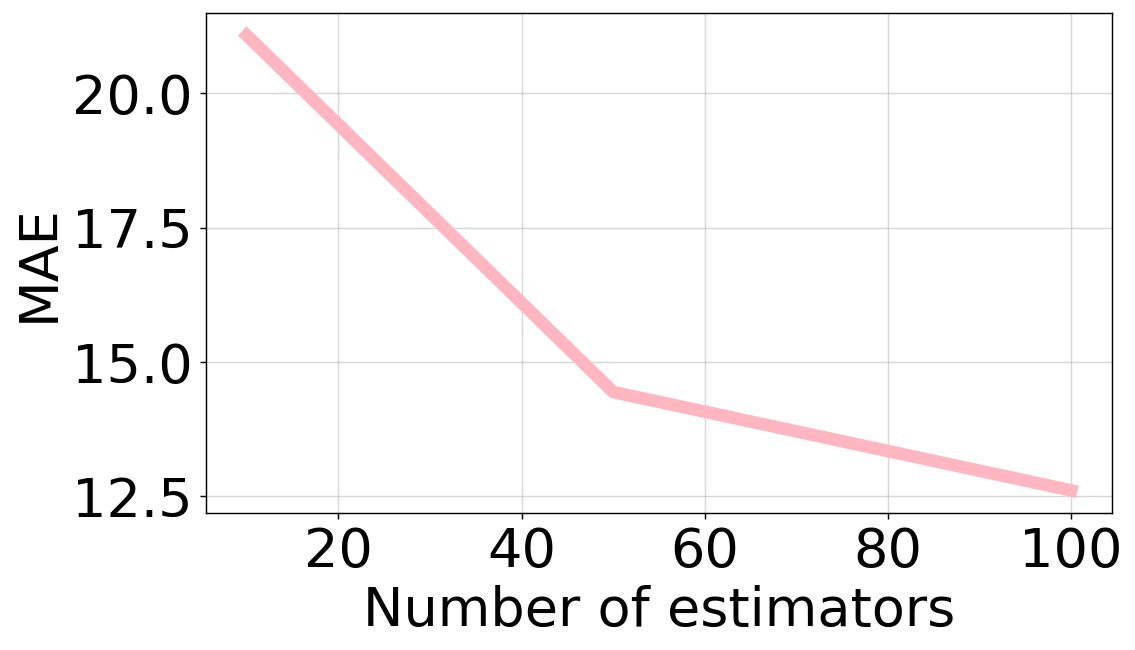

In [45]:
mae = []
#for Y_predict_brr in brr.staged_predict(X_test):
    #mae.append(mean_absolute_error(Y_test, Y_predict_brr))
for n_estimators in grid['n_estimators']:
    brr = BaggingRegressor(max_samples=5, n_estimators=n_estimators, n_jobs=-1, random_state=42).fit(X_train, Y_train)
    Y_predict_brr = brr.predict(X_test)
    mae.append(mean_absolute_error(Y_test, Y_predict_brr))
fig, ax = plt.subplots(figsize=(9, 5), dpi=130)
plt.subplot().tick_params(labelsize=30)
ax.plot(grid['n_estimators'], mae, color='lightpink', linewidth=7)
ax.set_xlabel('Number of estimators', fontsize=30)
ax.set_ylabel('MAE', fontsize=30)
ax.grid(True, alpha=0.5)
#plt.show()
plt.savefig("br_validation.pdf", format="pdf", bbox_inches="tight")

In [46]:
replica_actual = []
for i in range(len(X_test)):
    replica_actual.append(np.ceil((dataset[len(X_train)+i, 4] * X_test[i])/Y_test[i]))
    #replica_actual.append(dataset[len(X_train)+i,4])
    #replica_actual.append((Y_test[i]))


replica_svr_ = []
for i in range(len(X_test)):
    replica_svr_.append(np.ceil((dataset[len(X_train)+i, 4] * X_test[i])/Y_predict_brr[i]))
    #replica_svr_.append(np.ceil((Y_predict_brr[i])))

In [47]:
'''from scipy.interpolate import pchip

plt.figure(figsize=(9, 5), dpi=120)
plt.subplot().tick_params(labelsize=20)
N = X_test.shape[0] 
X_ = np.linspace(np.arange(N).min(), np.arange(N).max(), 200) 

X_Y_Spline = pchip(np.arange(N), np.array(np.ceil(replica_actual)))
Y_ = X_Y_Spline(X_)
plt.plot(X_,Y_, label='Without prediction', color="red", linestyle='dashed')

X_Y_Spline = pchip(np.arange(N), np.array(np.ceil(replica_svr_)))
Y_ = X_Y_Spline(X_)
plt.plot(X_,Y_,  label='SVR prediction', color="lightgreen", linestyle='dashed')

plt.ylabel('Number of replicas', fontsize=20)
plt.xlabel('Microservice #id', fontsize=20)
plt.legend(loc='upper center',bbox_to_anchor=(0.5, -0.2),fancybox=False, shadow=False, ncol=3, fontsize=20 )
#plt.show()
plt.savefig("NumberOfReplicas_SVR.pdf", format="pdf", bbox_inches="tight")'''

'from scipy.interpolate import pchip\n\nplt.figure(figsize=(9, 5), dpi=120)\nplt.subplot().tick_params(labelsize=20)\nN = X_test.shape[0] \nX_ = np.linspace(np.arange(N).min(), np.arange(N).max(), 200) \n\nX_Y_Spline = pchip(np.arange(N), np.array(np.ceil(replica_actual)))\nY_ = X_Y_Spline(X_)\nplt.plot(X_,Y_, label=\'Without prediction\', color="red", linestyle=\'dashed\')\n\nX_Y_Spline = pchip(np.arange(N), np.array(np.ceil(replica_svr_)))\nY_ = X_Y_Spline(X_)\nplt.plot(X_,Y_,  label=\'SVR prediction\', color="lightgreen", linestyle=\'dashed\')\n\nplt.ylabel(\'Number of replicas\', fontsize=20)\nplt.xlabel(\'Microservice #id\', fontsize=20)\nplt.legend(loc=\'upper center\',bbox_to_anchor=(0.5, -0.2),fancybox=False, shadow=False, ncol=3, fontsize=20 )\n#plt.show()\nplt.savefig("NumberOfReplicas_SVR.pdf", format="pdf", bbox_inches="tight")'

In [48]:
print()
print("MAPE : ", np.round(mean_absolute_percentage_error(np.array(replica_actual), np.array(replica_svr_)),4))

print("MAE : ", np.round(mean_absolute_error(np.array(replica_actual), np.array(replica_svr_)),4))

print("MSE : ", np.round(mean_squared_error(np.array(replica_actual), np.array(replica_svr_)),4))

print("RMSE : ", np.round(mean_squared_error(np.array(replica_actual), np.array(replica_svr_))**0.5,4))

print("Actual number of replicas (min.): ",np.round(np.min(np.array(replica_actual)),0))
print("Predicted number of replicas (min.): ",np.round(np.min(np.array(replica_svr_)),0))

print("Actual number of replicas (avg.): ",np.round(np.average(np.array(replica_actual)),0))
print("Predicted number of replicas (avg.): ",np.round(np.average(np.array(replica_svr_)),0))

print("Actual number of replicas (max.): ",np.round(np.max(np.array(replica_actual)),0))
print("Predicted number of replicas (max.): ",np.round(np.max(np.array(replica_svr_)),0))


MAPE :  0.0764
MAE :  0.9619
MSE :  18.7459
RMSE :  4.3297
Actual number of replicas (min.):  1
Predicted number of replicas (min.):  1
Actual number of replicas (avg.):  4.0
Predicted number of replicas (avg.):  3.0
Actual number of replicas (max.):  42
Predicted number of replicas (max.):  41


### MLP

In [49]:
from sklearn.neural_network import  MLPRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
'''model_nn = MLPRegressor(
    solver = 'adam', 
    max_iter = 10000
)

parameters_nn = {
    'hidden_layer_sizes': [
        (40, 20, 10, 5, 2, ),
        (40, 30, 20, 15, 12, 10, 8, 6, 4, 2, ),
        (100, 50, 25, 12, 6, 3, ), 
        (60, 50, 40, 30, 20, 10, ),
        (1000, 100, 10, ),
        (200, 100, 50, 25, 12, 6, 3, 2, ),  
    ],
    'activation': ['identity', 'logistic', 'tanh', 'relu'],
    'alpha': ss.loguniform(1e-5, 1e-3),
    'beta_1': ss.uniform(0.5, 0.5),
    'beta_2': ss.uniform(0.9, 0.1),
    'epsilon': ss.loguniform(1e-9, 1e-7),
    'learning_rate_init': ss.uniform(0.001, 0.8),
}

def halving_search(model, parameters):
    return model_selection.HalvingRandomSearchCV(
        estimator = model,
        param_distributions = parameters,
        n_candidates = search_n_candidates,
        factor = search_factor,
        aggressive_elimination = search_agg_elimination,
        cv = search_cv,
        scoring = search_scoring, 
        n_jobs = search_n_jobs,
        verbose = search_verbose,
        random_state=random_seed,
    )
# Rescale 
scaler_X = StandardScaler()
scaler_Y = StandardScaler()

# Fit and transform X_train, and fit (but not transform) y_train
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
Y_train_scaled = scaler_Y.fit_transform(Y_train)  # Reshape y if it's 1D

search_nn = halving_search(model_nn, parameters_nn).fit(X_train_scaled, Y_train_scaled)
# fill predictions
Y_predict_mlp_1 = search_nn.best_estimator_.predict(X_test_scaled)
#print(len(Y_predict_mlp_1))
print(search_nn.best_estimator_)'''

# Rescale 
scaler_X = StandardScaler()
scaler_Y = StandardScaler()

# Fit and transform X_train, and fit_transform Y_train
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
Y_train_scaled = scaler_Y.fit_transform(Y_train)  # Reshape y if it's 1D

mlp_sk_learn = MLPRegressor(hidden_layer_sizes=(1,),solver = 'adam', max_iter = 10000)
#MLPRegressor(alpha=0.0005349770235622181, beta_1=0.6150926341207776,beta_2=0.9499193379884753, epsilon=1.3931837441736628e-08,hidden_layer_sizes=(40, 20, 10, 5, 2),learning_rate_init=0.035883017403547005, max_iter=10000)
#MLPRegressor(activation='tanh', alpha=1.5378674782977684e-05, beta_1=0.7131529401616195, beta_2=0.947322067394571,epsilon=1.4467524001482124e-08,hidden_layer_sizes=(40, 20, 10, 5, 2),learning_rate_init=0.02265518782175209, max_iter=10000) 
#MLPRegressor(activation='logistic', alpha=0.00036032215317318735, beta_1=0.9747855267253711, beta_2=0.9662526866950044, epsilon=1.064494130729993e-09, hidden_layer_sizes=(40, 30, 20, 15, 12, 10, 8, 6, 4, 2),learning_rate_init=0.6713559259990431, max_iter=10000)#MLPRegressor(activation='logistic', alpha=0.0006955289646247587, beta_1=0.5415562463153012, beta_2=0.9277718561281033, epsilon=1.0440310373117892e-09, hidden_layer_sizes=(100, 50, 25, 12, 6, 3),learning_rate_init=0.10643828992351374, max_iter=10000)
#MLPRegressor(activation='relu', alpha=1e-05, batch_size=4, hidden_layer_sizes=(10,), learning_rate_init=0.01, max_iter=9, momentum=0.8, random_state=11, solver='sgd', tol=1e-05, verbose=True) # 
#print(mlp_sk_learn.get_params(True))
#{'activation': 'relu', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_fun': 15000, 'max_iter': 10000, 'momentum': 0.9, 'n_iter_no_change': 10, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': None, 'shuffle': True, 'solver': 'adam', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': False, 'warm_start': False}

# Train a model
mlp_sk_learn.fit(X_train_scaled,Y_train_scaled)

# Make predictions
Y_predict_mlp_scaled = mlp_sk_learn.predict(X_test_scaled)

# Inverse transform X_test
X_test_original = scaler_X.inverse_transform(X_test_scaled)


# Inverse transform the predictions and the actual Y_test to get back to the original scale
Y_predict_mlp = scaler_Y.inverse_transform(Y_predict_mlp_scaled.reshape(-1,1))
Y_predict_mlp = np.reshape(Y_predict_mlp, [Y_test.shape[0], 1])

C:\Users\b1108190\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


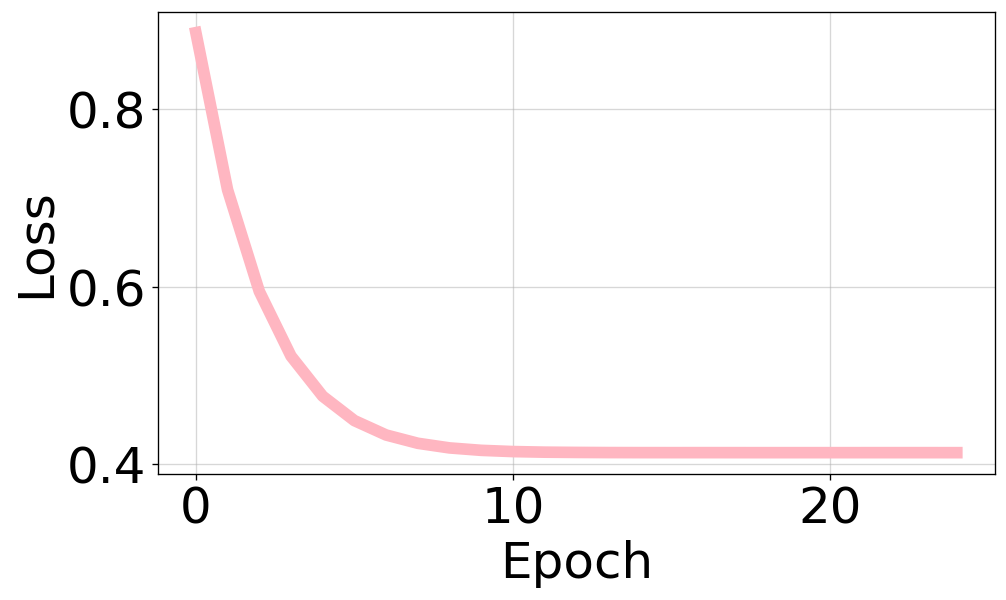

In [50]:
fig, ax = plt.subplots(figsize=(9, 5), dpi=120)
ax.plot(mlp_sk_learn.loss_curve_, color='lightpink', linewidth=7)
plt.subplot().tick_params(labelsize=30)
ax.set_xlabel('Epoch', fontsize=30)
ax.set_ylabel('Loss', fontsize=30)
#plt.yticks(range(8, 22, 2))
ax.grid(True, alpha=0.5)
#plt.show()
plt.savefig("mlp_validation.pdf", format="pdf", bbox_inches="tight")

In [51]:
mae = mean_absolute_error(Y_test, Y_predict_mlp)
mape = mean_absolute_percentage_error(Y_test, Y_predict_mlp)
mse = mean_squared_error(Y_test, Y_predict_mlp)
rmse_test = mse ** 0.5
#mape = mean_absolute_percentage_error(Y_val, Y_predict_mlp)
#mae = mean_absolute_error(Y_val, Y_predict_mlp)
#mse = mean_squared_error(Y_val, Y_predict_mlp)
print(f"MAPE : {mape}")
print(f"MAE : {mae}")
print(f"MSE : {mse}")
print(f"RMSE: {rmse_test}")

MAPE : 36.78573527036598
MAE : 47.17676134922957
MSE : 3045.4909049230027
RMSE: 55.185966557839706


In [52]:
replica_actual = []
for i in range(len(X_test)):
    replica_actual.append(np.ceil((dataset[len(X_train)+i, 4] * X_test[i])/Y_test[i]))
    #replica_actual.append(dataset[len(X_train)+i,4])   
    #replica_actual.append((Y_test[i]))
 
replica_mlp = []
for i in range(len(X_test)):
    replica_mlp.append(np.ceil((dataset[len(X_train)+i, 4] * X_test[i])/Y_predict_mlp[i]))
    #replica_svr_.append(np.ceil((Y_predict_mlp[i])))

In [53]:
'''plt.figure(figsize=(9, 5), dpi=120)
plt.subplot().tick_params(labelsize=20)
N = X_test.shape[0] 
X_ = np.linspace(np.arange(N).min(), np.arange(N).max(), 200)

X_Y_Spline = pchip(np.arange(N), np.array(np.ceil(replica_actual)))
Y_ = X_Y_Spline(X_)
plt.plot(X_,Y_, label='Without prediction', color="red", linestyle='dashed')

X_Y_Spline = pchip(np.arange(N), np.array(np.ceil(replica_mlp)))
Y_ = X_Y_Spline(X_)
plt.plot(X_,Y_,  label='MLP prediction', color="lightgreen", linestyle='dashed')

plt.ylabel('Number of replicas', fontsize=20)
plt.xlabel('Microservice #id', fontsize=20)
plt.legend(loc='upper center',bbox_to_anchor=(0.5, -0.2),fancybox=False, shadow=False, ncol=3, fontsize=20 )
#plt.show()
plt.savefig("NumberOfReplicas_dtr.pdf", format="pdf", bbox_inches="tight")'''

'plt.figure(figsize=(9, 5), dpi=120)\nplt.subplot().tick_params(labelsize=20)\nN = X_test.shape[0] \nX_ = np.linspace(np.arange(N).min(), np.arange(N).max(), 200)\n\nX_Y_Spline = pchip(np.arange(N), np.array(np.ceil(replica_actual)))\nY_ = X_Y_Spline(X_)\nplt.plot(X_,Y_, label=\'Without prediction\', color="red", linestyle=\'dashed\')\n\nX_Y_Spline = pchip(np.arange(N), np.array(np.ceil(replica_mlp)))\nY_ = X_Y_Spline(X_)\nplt.plot(X_,Y_,  label=\'MLP prediction\', color="lightgreen", linestyle=\'dashed\')\n\nplt.ylabel(\'Number of replicas\', fontsize=20)\nplt.xlabel(\'Microservice #id\', fontsize=20)\nplt.legend(loc=\'upper center\',bbox_to_anchor=(0.5, -0.2),fancybox=False, shadow=False, ncol=3, fontsize=20 )\n#plt.show()\nplt.savefig("NumberOfReplicas_dtr.pdf", format="pdf", bbox_inches="tight")'

In [54]:
print()

print("MAPE : ", np.round(mean_absolute_percentage_error(np.array(replica_actual), np.array(replica_mlp)),4))

print("MAE : ", np.round(mean_absolute_error(np.array(replica_actual), np.array(replica_mlp)),4))

print("MSE : ", np.round(mean_squared_error(np.array(replica_actual), np.array(replica_mlp)),4))

print("RMSE : ", np.round(mean_squared_error(np.array(replica_actual), np.array(replica_mlp))**0.5,4))

print("Actual number of replicas (min.): ",np.round(np.min(np.array(replica_actual)),0))
print("Predicted number of replicas (min.): ",np.round(np.min(np.array(replica_mlp)),0))

print("Actual number of replicas (avg.): ",np.round(np.average(np.array(replica_actual)),0))
print("Predicted number of replicas (avg.): ",np.round(np.average(np.array(replica_mlp)),0))

print("Actual number of replicas (max.): ",np.round(np.max(np.array(replica_actual)),0))
print("Predicted number of replicas (max.): ",np.round(np.max(np.array(replica_mlp)),0))


MAPE :  0.1771
MAE :  1.1229
MSE :  21.2613
RMSE :  4.611
Actual number of replicas (min.):  1
Predicted number of replicas (min.):  1
Actual number of replicas (avg.):  4.0
Predicted number of replicas (avg.):  3.0
Actual number of replicas (max.):  42
Predicted number of replicas (max.):  38
